In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',0)

In [3]:
df=pd.read_csv('yellow_tripdata_2023-01.csv',low_memory=False)

In [4]:
df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1437535,2,2023-01-16 13:19:51,2023-01-16 13:34:35,1.0,3.64,1.0,N,50,145,2,18.4,0.0,0.5,0.0,0.0,1.0,22.4,2.5,0.0
380516,2,2023-01-05 17:10:21,2023-01-05 17:43:49,1.0,3.61,1.0,N,48,137,2,28.9,2.5,0.5,0.0,0.0,1.0,35.4,2.5,0.0
967390,2,2023-01-11 20:16:59,2023-01-11 20:31:55,1.0,4.97,1.0,N,158,52,1,22.6,1.0,0.5,10.25,6.55,1.0,44.4,2.5,0.0


In [5]:
#total number of rows and column (3066812, 19)
df.shape

(3066812, 19)

In [6]:
#Check null value in all column
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

In [7]:
#Check distinct value in passenger_count column
print(df['passenger_count'].isnull().sum())

71743


## passenger_count, RatecodeID, store_and_fwd_flag, congestion_surcharge and airport_fee column has 71743 records of null value.

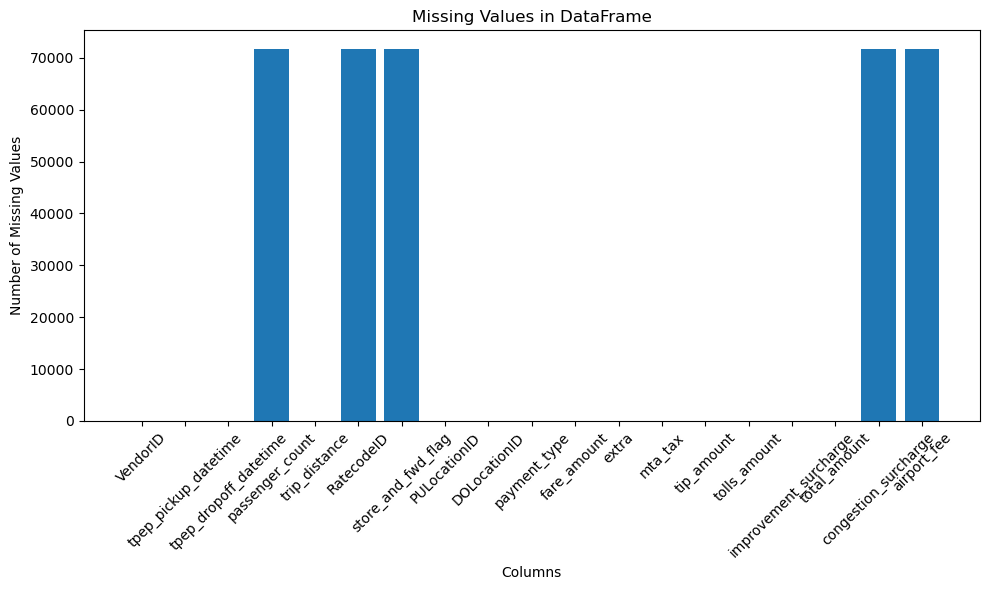

In [8]:
#Plot null value count with column

# Assuming df is your DataFrame
missing_values = df.isnull().sum()

# Creating a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [9]:
#Check the data types of all present column in df dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066812 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   VendorID               object
 1   tpep_pickup_datetime   object
 2   tpep_dropoff_datetime  object
 3   passenger_count        object
 4   trip_distance          object
 5   RatecodeID             object
 6   store_and_fwd_flag     object
 7   PULocationID           object
 8   DOLocationID           object
 9   payment_type           object
 10  fare_amount            object
 11  extra                  object
 12  mta_tax                object
 13  tip_amount             object
 14  tolls_amount           object
 15  improvement_surcharge  object
 16  total_amount           object
 17  congestion_surcharge   object
 18  airport_fee            object
dtypes: object(19)
memory usage: 444.6+ MB


In [10]:
distinct_count = len(df['VendorID'].unique())
print("Distinct value in VendorID column",df['VendorID'].unique())
print("Count of distinct values in 'VendorID' column:", distinct_count)

Distinct value in VendorID column ['2' '1' 'VendorID']
Count of distinct values in 'VendorID' column: 3


### For data better understanding let's load the both csv file in postgresql database but this is completely optional we can do all the data preparation part using pandas.

In [11]:
import psycopg2
import pandas as pd
from psycopg2 import extras

try:
    # Establishing the connection
    conn = psycopg2.connect(
        database="postgres", user='postgres', password='password', host='127.0.0.1', port='5432')
    
    # Creating a cursor object using the cursor() method
    cursor = conn.cursor()
    
    # Create table yellow_tripdata_2023_01 if not exists
    cursor.execute('''CREATE TABLE IF NOT EXISTS yellow_tripdata_2023_01 (
                            id SERIAL PRIMARY KEY,
                            VendorID TEXT, 
                            tpep_pickup_datetime TEXT,
                            tpep_dropoff_datetime TEXT,
                            passenger_count TEXT,
                            trip_distance TEXT,
                            RatecodeID TEXT,
                            store_and_fwd_flag TEXT,
                            PULocationID TEXT,
                            DOLocationID TEXT,
                            payment_type TEXT,
                            fare_amount TEXT,
                            extra TEXT,
                            mta_tax TEXT,
                            tip_amount TEXT,
                            tolls_amount TEXT,
                            improvement_surcharge TEXT,
                            total_amount TEXT,
                            congestion_surcharge TEXT,
                            airport_fee TEXT);''')
    
    # Commit the table creation
    conn.commit()
    print("Table 'yellow_tripdata_2023_01' created successfully")
    
    # Load CSV file into a DataFrame skipping the header row
    df = pd.read_csv('yellow_tripdata_2023-01.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    data = [tuple(row) for row in df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    insert_query = """
        INSERT INTO yellow_tripdata_2023_01 (VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
        trip_distance, RatecodeID, store_and_fwd_flag, PULocationID, DOLocationID, payment_type, fare_amount, extra, 
        mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, insert_query, data, page_size=100000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in yellow_tripdata_2023_01 table")
    
    
    # Create table taxi_zones if not exists
    cursor.execute('''create table taxi_zones(OBJECTID int PRIMARY KEY,
                                                    Shape_Leng float,
                                                    the_geom text,
                                                    Shape_Area float,
                                                    Zone text,
                                                    LocationID int,
                                                    Borough text);''')
    

    # Commit the table creation
    conn.commit()
    
    print("Table 'taxi_zones' created successfully")

    # Load CSV file into a DataFrame skipping the header row
    zone_df = pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv', low_memory=False) 
    
    # Prepare data as a list of tuples
    zone_data = [tuple(row) for row in zone_df.itertuples(index=False, name=None)]
    
    # Construct the INSERT INTO statement
    zone_insert_query = """
        INSERT INTO taxi_zones (OBJECTID,Shape_Leng,the_geom,Shape_Area,Zone,LocationID,Borough)
        VALUES %s
    """
    
    # Execute the INSERT INTO statement using execute_values()
    extras.execute_values(cursor, zone_insert_query, zone_data, page_size=1000) #page_size is number of rows to be inserted  
    
    # Committing the transaction
    conn.commit()
    print("Data inserted successfully in taxi_zones table")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL or inserting data:", error)

finally:
    # Closing the connection
    if conn:
        cursor.close()
        conn.close()
        print("PostgreSQL connection is closed")

Table 'yellow_tripdata_2023_01' created successfully
Data inserted successfully in yellow_tripdata_2023_01 table
Table 'taxi_zones' created successfully
Data inserted successfully in taxi_zones table
PostgreSQL connection is closed


In [12]:
from IPython.display import Image

# Use the raw URL of the image
image_url = "https://raw.githubusercontent.com/bibek376/Uber_Data_Engineering_Project/master/pictures/1.png"

# Display the image
Image(url=image_url)


In [13]:
#only garbage data
filtered_df = df[df['VendorID'] == 'VendorID']

In [14]:
#verify them by selecting random value
filtered_df.sample(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1066703,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
800027,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1533386,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
400013,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
533351,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


In [15]:
#calculate total number of garabge rows in csv file
filtered_df.shape

(46, 19)

In [16]:
#Select only the proper data
after_filtered_df=df[df['VendorID'] != 'VendorID']

#### According to data dictionary VendorID, RatecodeID, store_and_fwd_flag and payment_type are the categorical data

In [17]:
after_filtered_df['VendorID']=after_filtered_df['VendorID'].astype('category')
after_filtered_df['tpep_pickup_datetime']=pd.to_datetime(after_filtered_df['tpep_pickup_datetime'])
after_filtered_df['tpep_dropoff_datetime']=pd.to_datetime(after_filtered_df['tpep_dropoff_datetime'])
after_filtered_df['passenger_count']=pd.to_numeric(after_filtered_df['passenger_count'],downcast='integer')
after_filtered_df['trip_distance']=pd.to_numeric(after_filtered_df['trip_distance'])
after_filtered_df['RatecodeID']=after_filtered_df['RatecodeID'].astype('category')
after_filtered_df['store_and_fwd_flag']=after_filtered_df['store_and_fwd_flag'].astype('category')
after_filtered_df['PULocationID']=pd.to_numeric(after_filtered_df['PULocationID'])
after_filtered_df['DOLocationID']=pd.to_numeric(after_filtered_df['DOLocationID'])
after_filtered_df['payment_type']=after_filtered_df['payment_type'].astype('category')
after_filtered_df['fare_amount']=pd.to_numeric(after_filtered_df['fare_amount'])
after_filtered_df['extra']=pd.to_numeric(after_filtered_df['extra'])
after_filtered_df['mta_tax']=pd.to_numeric(after_filtered_df['mta_tax'])
after_filtered_df['tip_amount']=pd.to_numeric(after_filtered_df['tip_amount'])
after_filtered_df['tolls_amount']=pd.to_numeric(after_filtered_df['tolls_amount'])
after_filtered_df['improvement_surcharge']=pd.to_numeric(after_filtered_df['improvement_surcharge'])
after_filtered_df['total_amount']=pd.to_numeric(after_filtered_df['total_amount'])
after_filtered_df['congestion_surcharge']=pd.to_numeric(after_filtered_df['congestion_surcharge'])
after_filtered_df['airport_fee']=pd.to_numeric(after_filtered_df['airport_fee'])

In [18]:
#Check data type conversion
after_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066766 entries, 0 to 3066811
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee            floa

### check if there is same value in tpep_pickup_datetime and tpep_dropoff_datetime: if there is same value logically data is not useful

In [19]:
same_values=after_filtered_df['tpep_pickup_datetime'] == after_filtered_df['tpep_dropoff_datetime']
same_values_df = after_filtered_df[same_values]
print("Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same",same_values_df.shape[0])
same_values_df.sample(4)

Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same 1118


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
1059558,1,2023-01-12 18:46:17,2023-01-12 18:46:17,1.0,0.0,1.0,N,239,264,2,3.0,5.0,0.5,0.0,0.0,1.0,9.5,2.5,0.00
1515246,1,2023-01-17 12:55:33,2023-01-17 12:55:33,1.0,0.0,1.0,Y,145,264,2,7.2,0.0,0.5,0.0,0.0,1.0,8.7,0.0,0.00
2343875,1,2023-01-25 15:27:46,2023-01-25 15:27:46,1.0,0.0,1.0,N,138,264,2,3.0,2.5,0.5,0.0,0.0,1.0,7.0,0.0,1.25
2665357,1,2023-01-28 13:35:17,2023-01-28 13:35:17,1.0,0.0,1.0,N,164,264,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


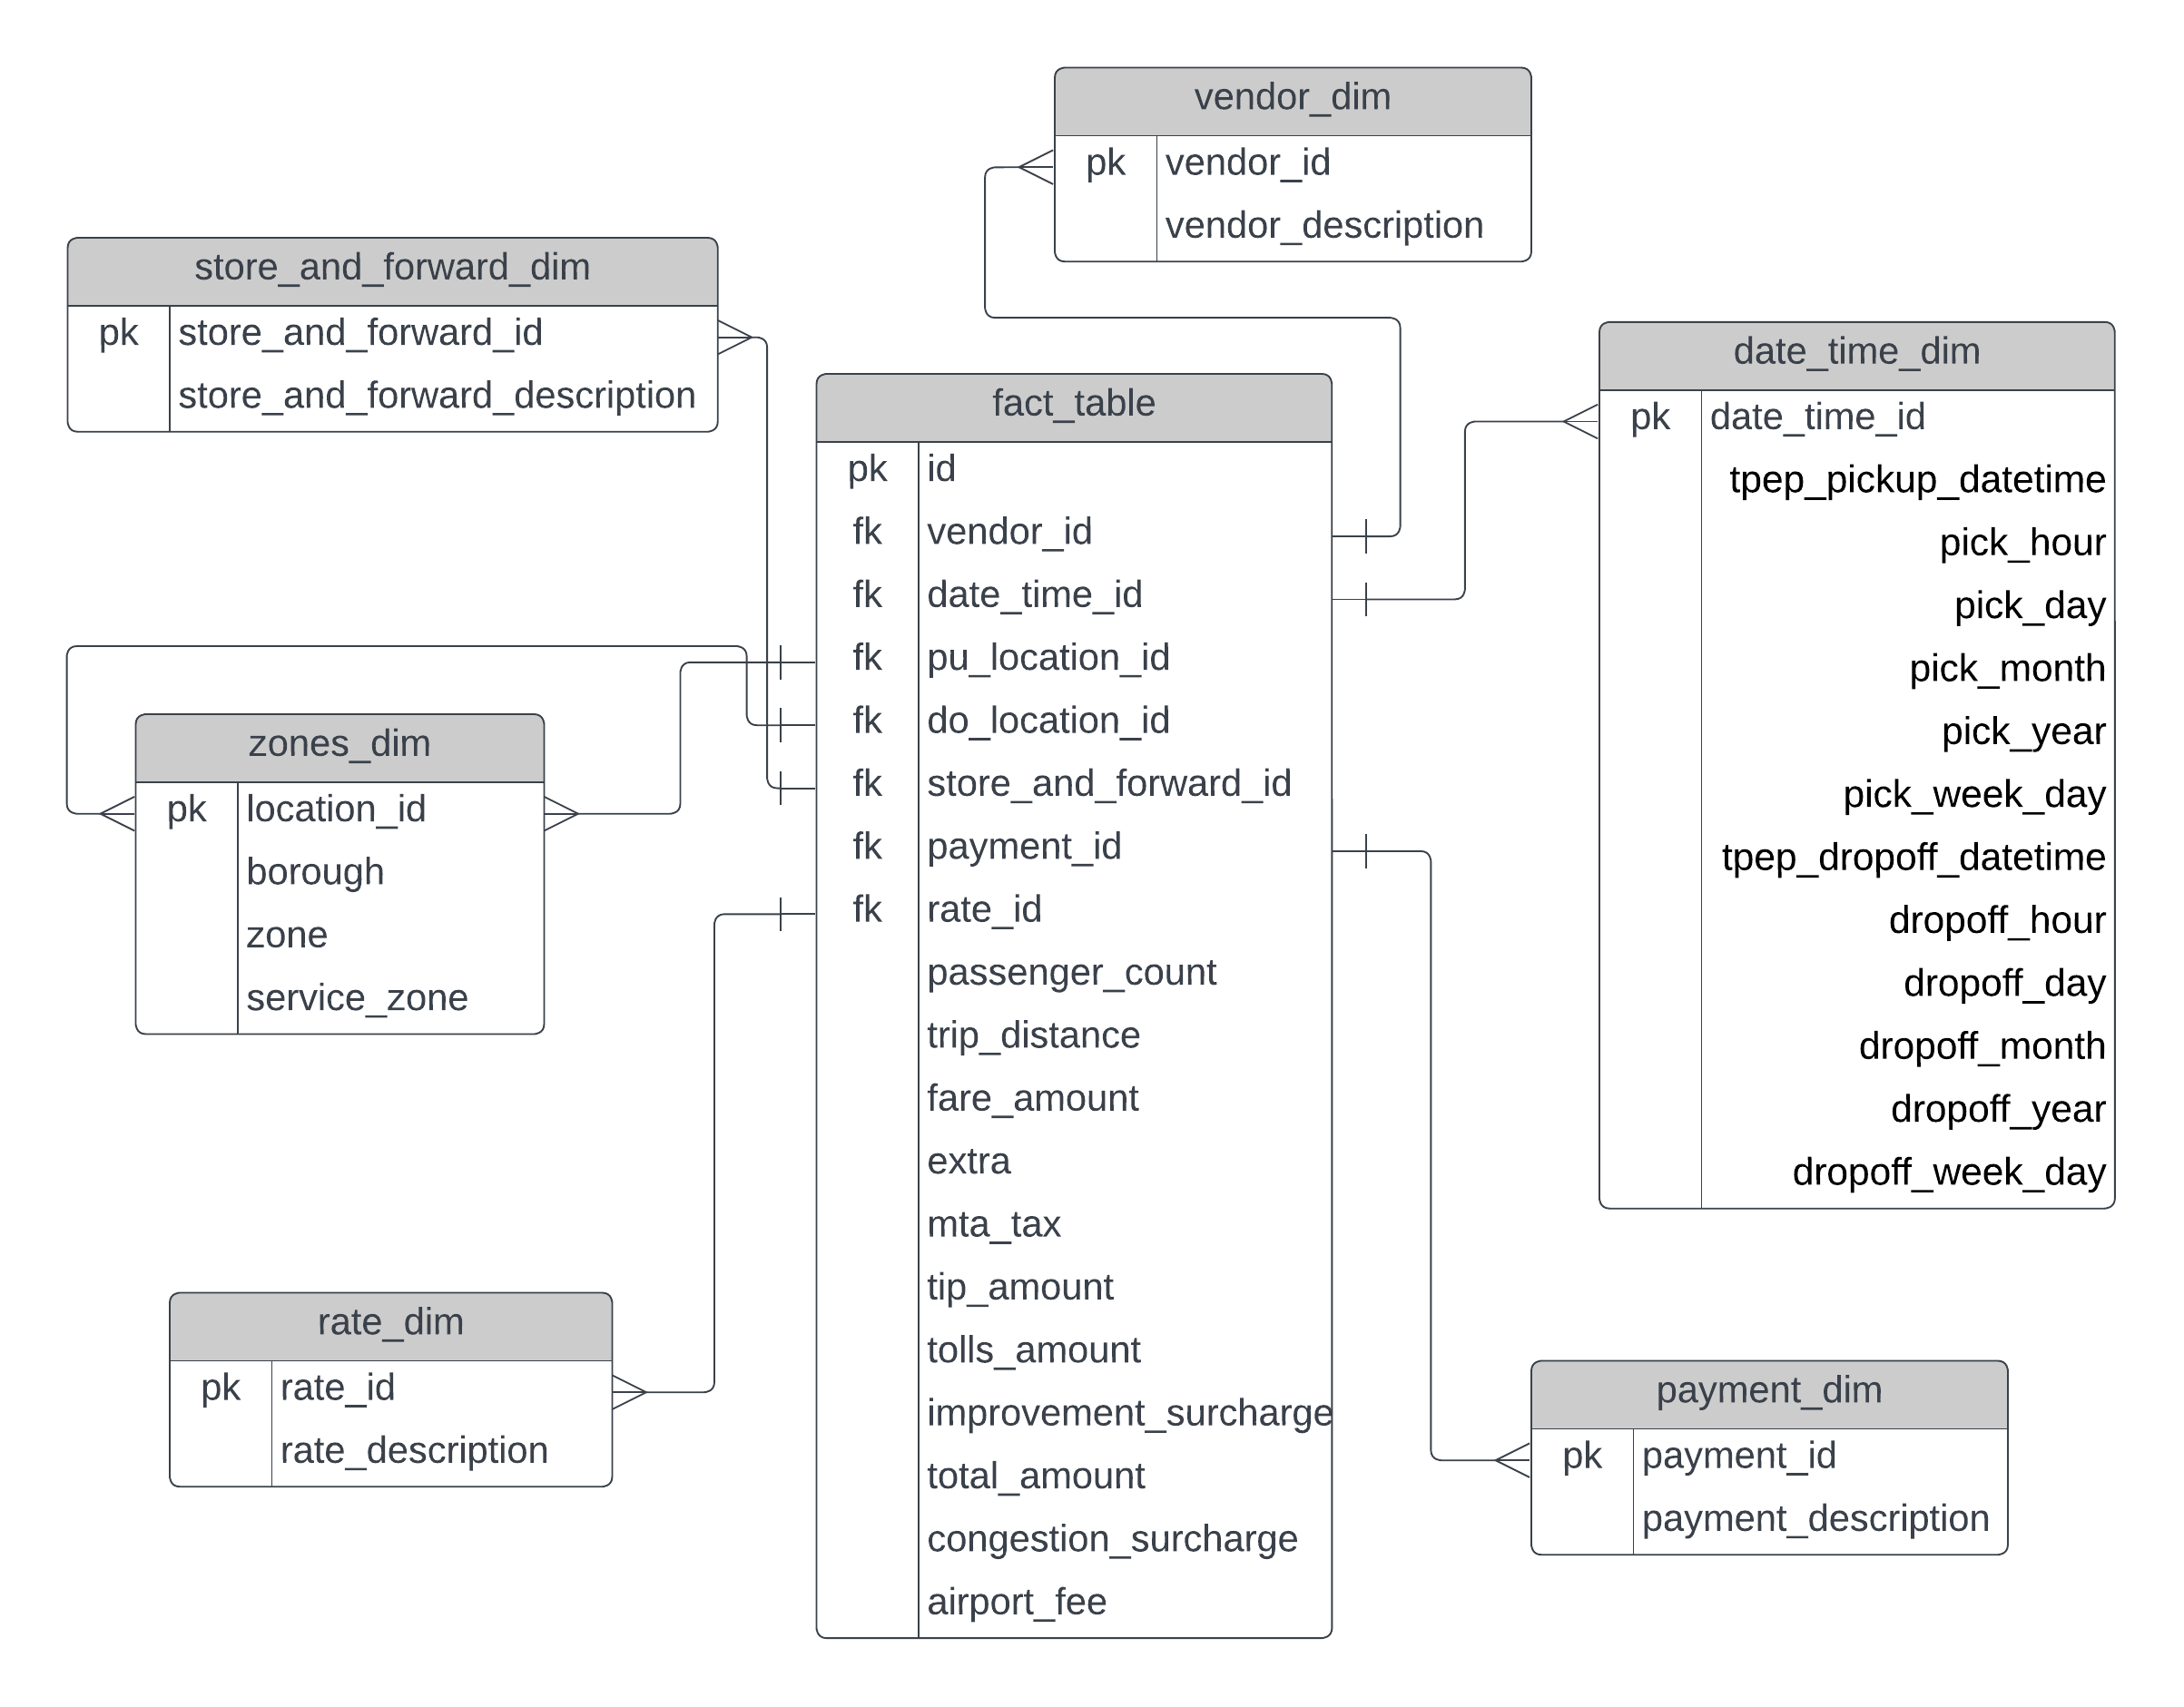

In [22]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/2.png")

### According to ER diagram now we have to create date and time dimension table where data can be identified on the basis of month, day and year. 

In [20]:
### Extract the year, month, day, weekday and hour data using tpep_pickup_datetime and tpep_dropoff_datetime
after_filtered_df['pickup_year'] = after_filtered_df['tpep_pickup_datetime'].dt.year
after_filtered_df['pickup_month'] = after_filtered_df['tpep_pickup_datetime'].dt.month
after_filtered_df['pickup_day'] = after_filtered_df['tpep_pickup_datetime'].dt.day
after_filtered_df['pickup_weekday'] = after_filtered_df['tpep_pickup_datetime'].dt.weekday
after_filtered_df['pickup_hour'] = after_filtered_df['tpep_pickup_datetime'].dt.hour
after_filtered_df['dropoff_year'] = after_filtered_df['tpep_dropoff_datetime'].dt.year
after_filtered_df['dropoff_month'] = after_filtered_df['tpep_dropoff_datetime'].dt.month
after_filtered_df['dropoff_day'] = after_filtered_df['tpep_dropoff_datetime'].dt.day
after_filtered_df['dropoff_weekday'] = after_filtered_df['tpep_dropoff_datetime'].dt.weekday
after_filtered_df['dropoff_hour'] = after_filtered_df['tpep_dropoff_datetime'].dt.hour

In [21]:
after_filtered_df.sample(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
944995,2,2023-01-11 17:14:42,2023-01-11 17:31:14,1.0,5.72,1.0,N,88,229,1,26.1,2.5,0.5,4.89,0.0,1.0,37.49,2.5,0.0,2023,1,11,2,17,2023,1,11,2,17
1367890,1,2023-01-15 16:08:19,2023-01-15 16:29:36,3.0,3.20,1.0,N,239,229,2,19.1,2.5,0.5,0.00,0.0,1.0,23.10,2.5,0.0,2023,1,15,6,16,2023,1,15,6,16
705672,1,2023-01-09 07:48:19,2023-01-09 08:20:08,1.0,5.90,1.0,N,143,87,1,29.6,2.5,0.5,7.39,0.0,1.0,40.99,2.5,0.0,2023,1,9,0,7,2023,1,9,0,8


In [22]:
#if tpep_pickup_datetime and tpep_dropoff_datetime is same logically it is not possible
after_duplicate_filtered_df=after_filtered_df['tpep_pickup_datetime'] != after_filtered_df['tpep_dropoff_datetime']
after_duplicate_filtered_df = after_filtered_df[after_duplicate_filtered_df]
after_duplicate_filtered_df.sample(4)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
2129614,2,2023-01-23 11:41:43,2023-01-23 11:55:29,1.0,2.17,1.0,N,263,239,1,14.2,0.0,0.5,3.64,0.0,1.0,21.84,2.5,0.0,2023,1,23,0,11,2023,1,23,0,11
2287772,2,2023-01-24 22:49:58,2023-01-24 23:06:17,5.0,3.57,1.0,N,48,41,1,19.8,1.0,0.5,4.96,0.0,1.0,29.76,2.5,0.0,2023,1,24,1,22,2023,1,24,1,23
563763,2,2023-01-07 15:56:21,2023-01-07 16:07:07,1.0,1.84,1.0,N,236,163,1,12.8,0.0,0.5,3.36,0.0,1.0,20.16,2.5,0.0,2023,1,7,5,15,2023,1,7,5,16
935236,2,2023-01-11 16:47:33,2023-01-11 16:56:08,2.0,1.12,1.0,N,236,237,1,10.0,2.5,0.5,2.48,0.0,1.0,18.98,2.5,0.0,2023,1,11,2,16,2023,1,11,2,16


In [23]:
print("Initial number of row count in yellow_tripdata_2023-01.csv file",df.shape[0], "and column is ",df.shape[1])
print("After Deleting garbage value row count is ",after_filtered_df.shape[0], 
      "and column is",after_filtered_df.shape[1])
print("Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same",same_values_df.shape[0])
print("Number of rows after drop same value",after_duplicate_filtered_df.shape[0])

print("Number of Rows after data cleaning process",df.shape[0]-46-same_values_df.shape[0])

Initial number of row count in yellow_tripdata_2023-01.csv file 3066812 and column is  19
After Deleting garbage value row count is  3066766 and column is 29
Number of rows where tpep_pickup_datetime and tpep_dropoff_datetime is same 1118
Number of rows after drop same value 3065648
Number of Rows after data cleaning process 3065648


### let's explore taxi+_zone_lookup.csv file

In [24]:
df_taxi_zone=pd.read_csv('/home/bibek/Desktop/uber_data_engineering/data/taxi_zones.csv')
df_taxi_zone.sample(3)

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
123,121,0.096915,MULTIPOLYGON (((-73.79911195699995 40.73820613...,0.000385,Hillcrest/Pomonok,121,Queens
227,228,0.177685,MULTIPOLYGON (((-73.9969179149999 40.669153483...,0.000993,Sunset Park West,228,Brooklyn
170,169,0.060105,MULTIPOLYGON (((-73.89816577499982 40.85514637...,0.000146,Mount Hope,169,Bronx


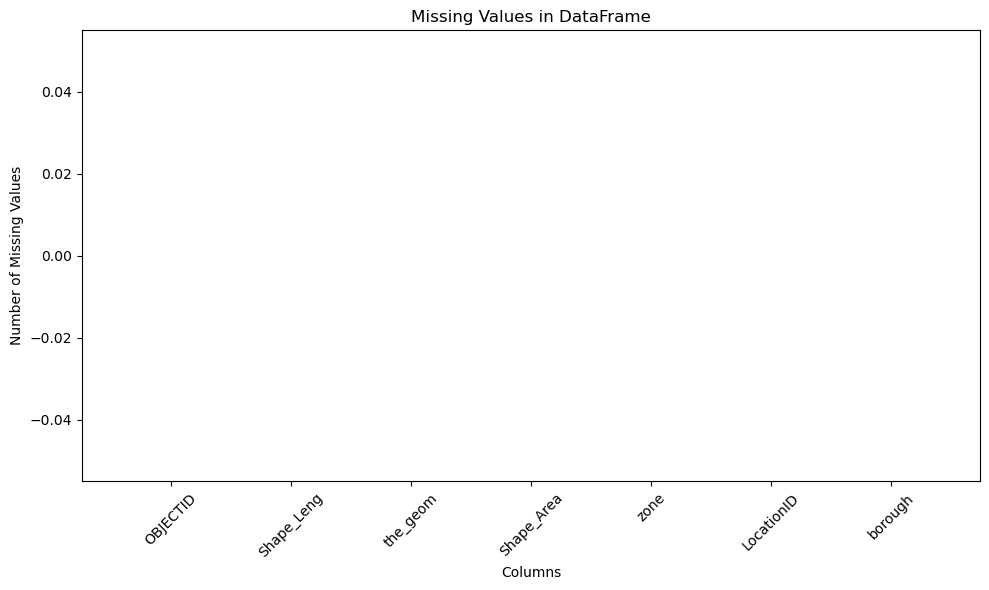

In [25]:
# Assuming df is your DataFrame
missing_values = df_taxi_zone.isnull().sum()

# Creating a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(missing_values.index, missing_values.values)
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [26]:
#dataset is fine and no need to do anything 
df_taxi_zone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    263 non-null    int64  
 1   Shape_Leng  263 non-null    float64
 2   the_geom    263 non-null    object 
 3   Shape_Area  263 non-null    float64
 4   zone        263 non-null    object 
 5   LocationID  263 non-null    int64  
 6   borough     263 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 14.5+ KB


In [27]:
after_duplicate_filtered_df.head(8).reset_index(drop=True)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,2023,1,1,6,0,2023,1,1,6,1
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,2023,1,1,6,0,2023,1,1,6,0
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
5,2,2023-01-01 00:50:34,2023-01-01 01:02:52,1.0,1.84,1.0,N,161,137,1,12.8,1.00,0.5,10.00,0.0,1.0,27.80,2.5,0.00,2023,1,1,6,0,2023,1,1,6,1
6,2,2023-01-01 00:09:22,2023-01-01 00:19:49,1.0,1.66,1.0,N,239,143,1,12.1,1.00,0.5,3.42,0.0,1.0,20.52,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0
7,2,2023-01-01 00:27:12,2023-01-01 00:49:56,1.0,11.70,1.0,N,142,200,1,45.7,1.00,0.5,10.74,3.0,1.0,64.44,2.5,0.00,2023,1,1,6,0,2023,1,1,6,0


### Create all table using data warehouse ER diagram

In [28]:
#prepare data for date_time_dim table
date_time_dim=after_duplicate_filtered_df[['tpep_pickup_datetime','pickup_year','pickup_month',
               'pickup_day','pickup_weekday','pickup_hour','tpep_dropoff_datetime',
              'dropoff_year','dropoff_month','dropoff_day','dropoff_weekday','dropoff_hour']]

In [29]:
date_time_dim.sample(2).reset_index(drop=True)

,tpep_pickup_datetime,pickup_year,pickup_month,pickup_day,pickup_weekday,pickup_hour,tpep_dropoff_datetime,dropoff_year,dropoff_month,dropoff_day,dropoff_weekday,dropoff_hour
0,2023-01-19 16:55:52,2023,1,19,3,16,2023-01-19 17:46:26,2023,1,19,3,17
1,2023-01-19 10:34:16,2023,1,19,3,10,2023-01-19 10:39:29,2023,1,19,3,10


### VendorID - A code indicating the TPEP provider that provided the record.
#### 1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.

In [30]:
# #prepare data for vendor_dim table
# vendor_mode={
#     1:"Creative Mobile Technologies, LLC",
#     2:"VeriFone Inc."
# }
# after_duplicate_filtered_df['vendor_description']=after_duplicate_filtered_df['VendorID'].map(vendor_mode)
# vendor_dim=after_duplicate_filtered_df[['VendorID','vendor_description']]

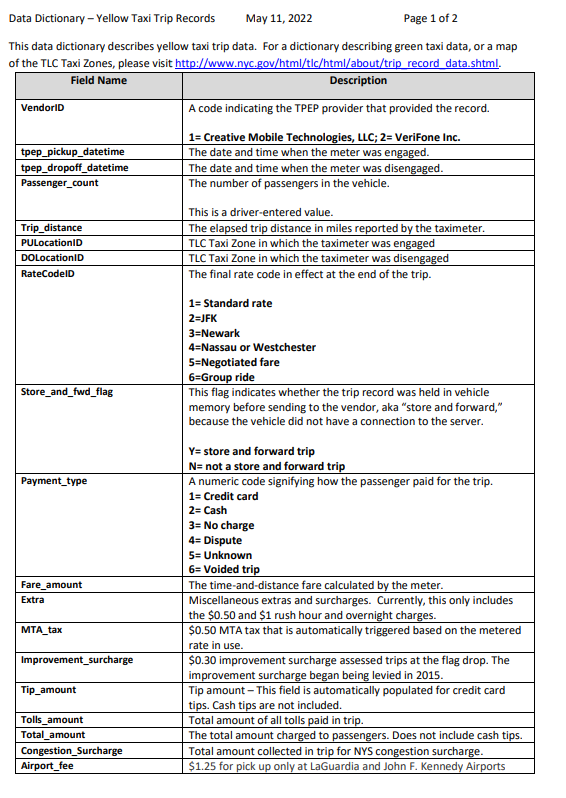

In [35]:
from IPython import display
display.Image("/home/bibek/Desktop/uber_data_engineering/pictures/3.png")

### According to data dictionary VendorId, RateCodeId, Store_and_fwd_flag